In [ ]:
#import mdptoolbox
#import mdptoolbox.example
import numpy as np
#import itertools
from matplotlib import pyplot as plt 
import copy
import time
import pandas as pd
from scipy.stats import betabinom
import bisect

### Single-Machine Production MDP Problem

In this problem, we consider a single-machine production system where the machine produces items at a rate of $ \mu $ products per unit time. The demand for the products is driven by a stochastic process, arriving at a rate $ \lambda $. The machine manager's goal is to find the optimal production policy that minimizes the total average cost, which includes holding costs and lost sales costs.

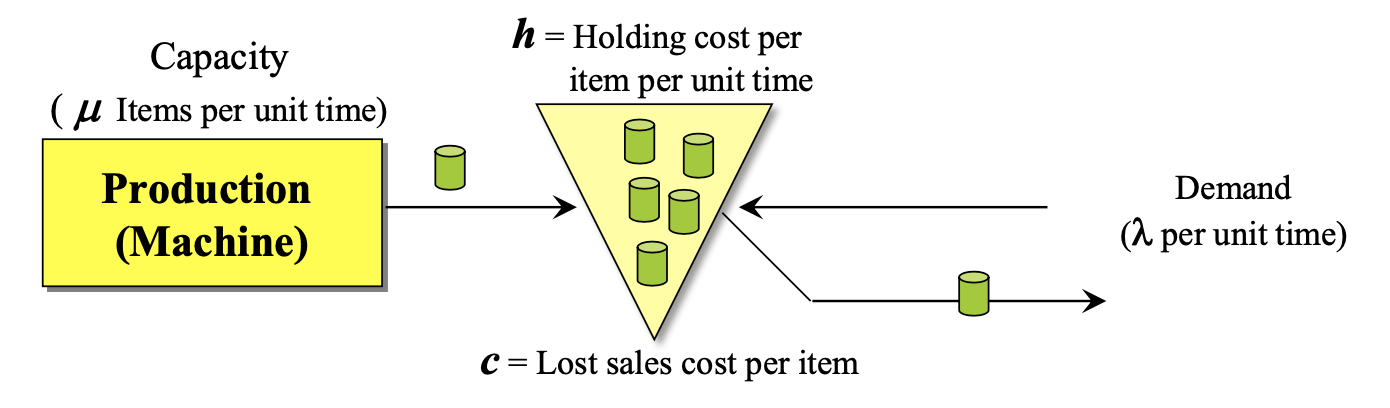

#### Components of the MDP

1. **States**:
   - The system's state is defined by the number of items in inventory at any given time, denoted as $ n $.

2. **Actions**:
   - The decision to either:
     - **Produce**: The machine starts producing an item.
     - **Idle**: The machine does not produce an item.
   
3. **Costs**:
   - **Holding cost**: A cost of $ h $ per product per unit time is incurred for each item held in inventory.
   - **Lost sales cost**: If the demand arrives and there is no product in inventory, a lost sales cost of \( c \) is incurred per unit of unmet demand.

4. **Decision Epochs**:
   - Decision epochs occur at two key instances:
     1. **Production completion epochs**: When a product is completed.
     2. **Demand arrival epochs**: When a customer arrives to purchase a product.

#### Bellman Equation for the Value Iteration Algorithm

The goal is to minimize the total expected cost by determining the optimal policy for production. The Bellman equation is used to recursively find the optimal cost at each state.

Let $ V_k(n) $ be the optimal expected cost when there are $ k $ periods remaining, and the system is in state $ n $. The value function $ V_k(n) $ is given by:

- When $ n = 0 $ (no items in inventory):

$$
V_k(0) = \min \left( c + V_{k-1}(0), \ \frac{\lambda}{\lambda + \mu} \cdot (V_{k-1}(0) + c) + \frac{\mu}{\lambda + \mu} \cdot V_{k-1}(1) \right)
$$
  
- When $ n > 0 $ (positive inventory):

$$
V_k(n) = \min \left( h \cdot \frac{n}{\lambda} + c + V_{k-1}(0), \ \frac{h \cdot n}{\lambda + \mu} + \frac{\lambda}{\lambda + \mu} \cdot (V_{k-1}(0) + c) + \frac{\mu}{\lambda + \mu} \cdot V_{k-1}(n+1) \right)
$$

The value iteration algorithm starts with an initial guess $ V_0(n) = 0 $ for all states and iteratively solves for \( V_k(n) \) using the Bellman equation until convergence.

#### Objective

The objective of this MDP is to find the **optimal production policy** that minimizes the total average cost, which includes the holding and lost sales costs. The value iteration algorithm is employed to find the optimal policy by iterating over possible states and actions until the value function converges.


In [ ]:
# Define the State class
class State():
    def __init__(self, inventory):
        """
        Initializes the state with the number of items in inventory.
        
        Parameters:
        inventory (int): Number of items in the inventory.
        """
        self.inventory = inventory

    def __hash__(self):
        """
        Defines the hash function to allow State objects to be used in dictionaries.
        """
        return hash(self.inventory)

    def __eq__(self, other):
        """
        Compares two states for equality.
        """
        return self.inventory == other.inventory

    def __repr__(self):
        """
        Provides a readable representation of the state.
        """
        return f"Inventory: {self.inventory}"


In [ ]:
def bellman_eq_action(k, n, V, lambda_rate, mu, h, c):
    """
    Bellman equation to compute V_k(n) using V_{k-1}(n) and determine the optimal action.
    
    Parameters:
    k (int): Number of periods remaining.
    n (int): Current state (inventory level).
    V (dict): Dictionary storing V_{k-1}(n) values for all n.
    lambda_rate (float): Demand rate.
    mu (float): Production rate.
    h (float): Holding cost per unit.
    c (float): Lost sales cost per unit.
    
    Returns:
    float: Optimal cost for state n at decision epoch k.
    str: Optimal action for state n at decision epoch k ("Produce" or "Idle").
    """
    if k == 0:
        return 0, "Idle"  # No cost in the initial state, and "Idle" is irrelevant
    
    if n == 0:
        idle_cost = c + V[k-1][0]
        produce_cost = (lambda_rate / (lambda_rate + mu)) * (V[k-1][0] + c) + (mu / (lambda_rate + mu)) * V[k-1][1]
    else:
        idle_cost = h * n / lambda_rate + c + V[k-1][0]
        produce_cost = h * n / (lambda_rate + mu) + (lambda_rate / (lambda_rate + mu)) * (V[k-1][0] + c) + (mu / (lambda_rate + mu)) * V[k-1][min(n+1, len(V[k-1])-1)]
    
    if idle_cost < produce_cost:
        return idle_cost, "Idle"
    else:
        return produce_cost, "Produce"


In [ ]:
def value_iteration_with_actions(max_inventory, lambda_rate, mu, h, c, tolerance=0.025):
    """
    Value iteration algorithm to compute the optimal actions for each state with a stopping criterion.
    
    Parameters:
    max_inventory (int): Maximum inventory level to consider.
    lambda_rate (float): Demand rate.
    mu (float): Production rate.
    h (float): Holding cost per unit.
    c (float): Lost sales cost per unit.
    tolerance (float): Error tolerance for convergence.
    
    Returns:
    dict: Dictionary containing optimal costs for each inventory state after convergence.
    dict: Dictionary containing the optimal action for each state.
    """
    L = max_inventory + 1
    V = {0: np.zeros(L)}
    actions = {}  # Initialize actions as an empty dictionary
    
    err = np.inf
    iter = 1
    newV = 100 * np.random.rand(L)
    
    while err > tolerance:
        V[iter] = np.zeros(L)
        
        # Update value function and store optimal action
        for n in range(L):
            V[iter][n], optimal_action = bellman_eq_action(iter, n, V, lambda_rate, mu, h, c)
            actions[n] = optimal_action  # Store the optimal action for state n
        
        # Calculate the error between current and new value function
        npmax, npmin = np.max(V[iter] - V[iter-1]), np.min(V[iter] - V[iter-1])
        err = (npmax - npmin) / npmax
        b, aa = npmax, npmin
        
        # Update for the next iteration
        iter += 1
        
        # Print the iteration and error for convergence tracking
        print(f"Iteration: {iter}, Error: {err:.4f}, b: {b:.4f}, aa: {aa:.4f}")
    
    print(f"Converged after {iter} iterations.")
    return V, actions

In [ ]:
def plot_optimal_actions(actions, max_inventory):
    """
    Plots the optimal actions for each state after convergence.
    
    Parameters:
    actions (dict): Dictionary containing the optimal actions for each state.
    max_inventory (int): Maximum inventory level.
    """
    inventory_states = range(max_inventory + 1)
    
    # Create a color map for actions
    colors = ['green' if actions[n] == 'Produce' else 'red' for n in inventory_states]
    
    # Plot the action boundaries
    plt.bar(inventory_states, [1] * len(inventory_states), color=colors, edgecolor='black')
    
    plt.xlabel('Inventory Level')
    plt.ylabel('Optimal Action')
    plt.title('Optimal Actions Across Inventory Levels After Convergence')
    
    # Creating a custom legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='green', edgecolor='black', label='Produce'),
                       Patch(facecolor='red', edgecolor='black', label='Idle')]
    plt.legend(handles=legend_elements)
    
    plt.show()



In [ ]:
# Example parameters for the MDP
max_inventory = 20
lambda_rate = 1.0
mu = 1.5
h = 0.5
c = 0.47
tolerance = 0.025

# Run value iteration with actions
V, actions = value_iteration_with_actions(max_inventory, lambda_rate, mu, h, c, tolerance)

In [ ]:
# Print the dictionary of actions for each state
print("Optimal actions for each state (n):")
for state, action in actions.items():
    print(f"State {state}: {action}")

In [ ]:
# Plot the optimal actions
plot_optimal_actions(actions, max_inventory)